<a href="https://colab.research.google.com/github/vikramwakhlu/Time_Series_Modelling/blob/main/1_Time_Series_W1_Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Data Load

In [2]:
# Install gdown
!pip install -U gdown

# Imports and helper functions
import pandas as pd
import requests
import io
import gdown

# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Read all files but train.csv (already done in previous runs, keeping for context)
# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))

#Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

#Load stores and get Guayas store IDs
stores_url = make_drive_url(file_ids["stores"])
df_stores = pd.read_csv(io.StringIO(requests.get(stores_url).text))
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()


#Read train.csv in chunks and filter for Guayas region
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk

#Combine and sample
df_train = pd.concat(filtered_chunks, ignore_index=True).sample(n=2_000_000).reset_index(drop=True)

# Ensure date column is datetime
df_train['date'] = pd.to_datetime(df_train['date'])

#Identify the top-3 families by item count
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # here is where we get the top-3 families

# Next, we filter our the dataset
# Get the list of item_nbrs that belong to those families
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()

# Filter the training data
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

# STEP 9: Clean up memory
del filtered_chunks

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=6b8c8e1c-eb41-4b57-a479-c9e2813caf82
To: /content/train.csv
100%|██████████| 5.00G/5.00G [00:56<00:00, 88.4MB/s]
/tmp/ipython-input-2742755233.py:52: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("train.csv", chunksize=chunk_size):


In [3]:
#Confirming top 3 families
top_3_families

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Save
df_train.to_parquet("/content/drive/MyDrive/df_train.parquet", index=False)


Mounted at /content/drive


In [3]:
# Reload
import pandas as pd
df_train = pd.read_parquet("/content/drive/MyDrive/df_train.parquet")

In [4]:
df_train.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,52929151,2015-08-02,30,514597,2.0,False
1,13574713,2013-11-06,27,581078,2.0,None
2,66621226,2016-01-03,34,876663,12.0,False
3,107179854,2017-02-23,28,2026983,4.0,False
4,42320365,2015-03-05,30,812725,1.0,False


#EDA


###Checking for Missing Data

In [5]:
# Checking missing values
df_train.isnull().sum()
#df_holiday_events.isnull().sum() - No missing values
#df_items.isnull().sum() - No missing values
#df_stores.isnull().sum() - No missing values
#df_transactions.isnull().sum() - No missing values

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,238495


In [6]:
# Checking missing values for df_oil
df_oil.isnull().sum()

,0
date,0
dcoilwtico,43


In [7]:
df_oil.shape
#appear to be enough data points to drop nulls values in df_oil

(1218, 2)

In [8]:
# Focusing on missing values in the 'onpromotion' column in df_train

# Check if 'onpromotion' column exists
if 'onpromotion' in df_train.columns:
    df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)
    print("Missing values in 'onpromotion' column handled.")
else:
    print("Column 'onpromotion' not found in df_train.")

Missing values in 'onpromotion' column handled.


/tmp/ipython-input-2905198075.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


In [9]:
df_oil.dropna(inplace=True)
df_oil.isnull().sum()

,0
date,0
dcoilwtico,0


In [10]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


###Handling Outliers

In [11]:
df_train.describe()

,id,date,store_nbr,item_nbr,unit_sales
count,1.285061e+06,1285061,1.285061e+06,1.285061e+06,1.285061e+06
mean,6.153414e+07,2015-08-30 12:30:43.190945024,3.245812e+01,9.037263e+05,6.805725e+00
min,1.880800e+04,2013-01-02 00:00:00,2.400000e+01,9.699500e+04,-1.020000e+02
25%,2.995334e+07,2014-08-31 00:00:00,2.700000e+01,4.280540e+05,2.000000e+00
50%,6.087761e+07,2015-11-01 00:00:00,3.000000e+01,8.902130e+05,3.000000e+00
75%,9.298454e+07,2016-10-05 00:00:00,3.500000e+01,1.213906e+06,7.000000e+00
max,1.254915e+08,2017-08-15 00:00:00,5.100000e+01,2.127114e+06,3.502000e+03
std,3.636284e+07,NaN,7.851617e+00,5.232207e+05,1.637177e+01


In [12]:
# Replacing negative sales with 0 to reflect returns as non-sales

# Check if 'unit_sales' column exists before processing
if 'unit_sales' in df_train.columns:
    df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))
    print("Negative unit sales replaced with 0.")
    display(df_train.describe())
else:
    print("Column 'unit_sales' not found in df_train.")
    print("Available columns:", df_train.columns)

Negative unit sales replaced with 0.


,id,date,store_nbr,item_nbr,unit_sales
count,1.285061e+06,1285061,1.285061e+06,1.285061e+06,1.285061e+06
mean,6.153414e+07,2015-08-30 12:30:43.190945024,3.245812e+01,9.037263e+05,6.806108e+00
min,1.880800e+04,2013-01-02 00:00:00,2.400000e+01,9.699500e+04,0.000000e+00
25%,2.995334e+07,2014-08-31 00:00:00,2.700000e+01,4.280540e+05,2.000000e+00
50%,6.087761e+07,2015-11-01 00:00:00,3.000000e+01,8.902130e+05,3.000000e+00
75%,9.298454e+07,2016-10-05 00:00:00,3.500000e+01,1.213906e+06,7.000000e+00
max,1.254915e+08,2017-08-15 00:00:00,5.100000e+01,2.127114e+06,3.502000e+03
std,3.636284e+07,NaN,7.851617e+00,5.232207e+05,1.637114e+01


In [13]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score for unit_sales (avoiding division by zero for standard deviation), and store it in a new column called z_score
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group, then flatten the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 3559


/tmp/ipython-input-1326790782.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
173,58206382,2015-10-03,24,105574,55.0,False,5.751631
478,461985,2013-01-13,24,105693,29.0,False,6.963425
812,37791483,2014-12-20,24,105857,67.0,False,6.791382
813,37125908,2014-12-11,24,105857,55.0,False,5.465423
951,47159290,2015-05-21,24,108079,17.0,False,5.470331


##Ensuring the dates are sequential

In [14]:
# Make sure the date column is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

In [15]:
import pandas as pd

# Make sure the date column is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

def fill_calendar(group):
    #
    # group contains all rows for ONE (store_nbr, item_nbr) pair
    #
    g = group.set_index("date").sort_index()   # use calendar as the index
    g = g.asfreq("D", fill_value=0)            # make it daily; add 0 where missing

    # put the identifiers back (asfreq drops them)
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"]  = group["item_nbr"].iloc[0]

    return g.reset_index()                     # date back to a normal column

df_train = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar)
)

df_train.head()

/tmp/ipython-input-3420849874.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-27,1028557,24,96995,1.0,False
1,2013-01-28,0,24,96995,0.0,0
2,2013-01-29,0,24,96995,0.0,0
3,2013-01-30,0,24,96995,0.0,0
4,2013-01-31,0,24,96995,0.0,0


#Feature Engineering

In [16]:
##Adding Year, Month, Day, and Day of Week extracted from the date column:

# Make sure 'date' is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Split the timestamp into model-friendly parts
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek # Monday=0 … Sunday=6

# Lets check the result
df_train.head()

df_train.to_csv("df_train_features.csv", index=False)

In [17]:
# Building a 7-day rolling average

# 7-day rolling average of unit_sales, per (item, store)
df_train = df_train.sort_values(["item_nbr", "store_nbr", "date"]).reset_index(drop=True) # make sure rows are in time order

df_train["unit_sales_7d_avg"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]      # isolate one time-series per (item, store), get the units sold
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())       #  mean of last 7 days, i.e. 7-day moving average, aligned back to original df
)

df_train.to_csv("df_train_features_sda.csv", index=False)

In [18]:
# Lets see how the new column unit_sales_7d_avg looks like. For that, we'll need to select a store and item.
# Get store and item from the first row
store_id = df_train.iloc[0]['store_nbr']
item_id = df_train.iloc[0]['item_nbr']

# Filter the DataFrame for this store-item pair
sample = df_train[(df_train['store_nbr'] == store_id) & (df_train['item_nbr'] == item_id)]
sample.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-27,1028557,24,96995,1.0,False,2013,1,27,6,1.000000
1,2013-01-28,0,24,96995,0.0,0,2013,1,28,0,0.500000
2,2013-01-29,0,24,96995,0.0,0,2013,1,29,1,0.333333
3,2013-01-30,0,24,96995,0.0,0,2013,1,30,2,0.250000
4,2013-01-31,0,24,96995,0.0,0,2013,1,31,3,0.200000


#Visualizing the data

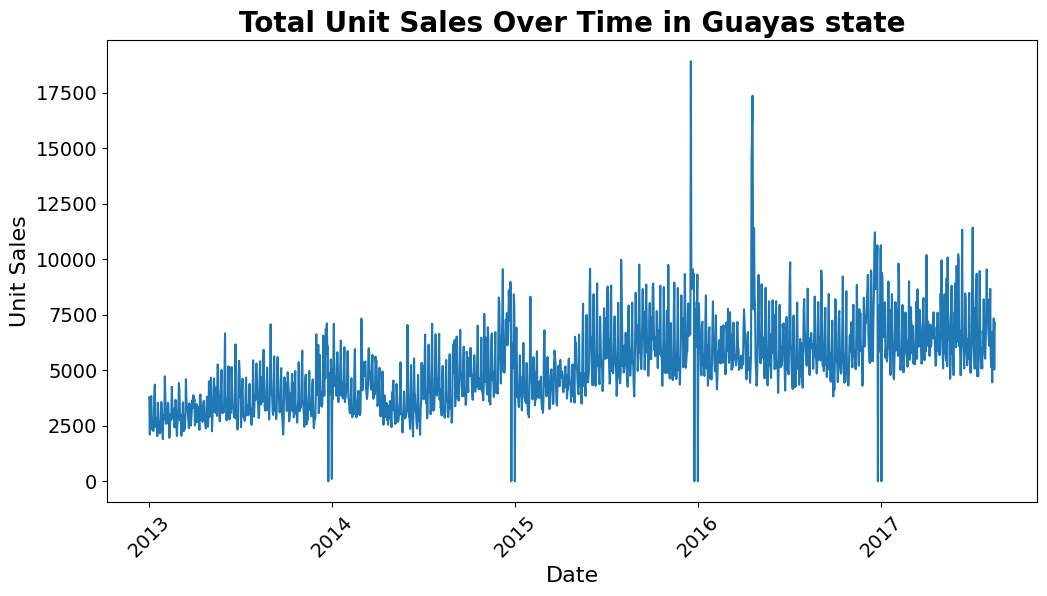

In [19]:
import matplotlib.pyplot as plt

# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [20]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

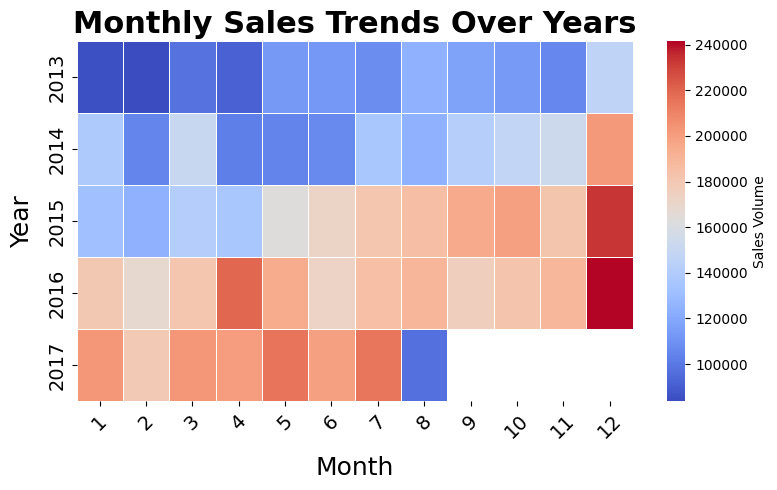

In [21]:
# Plotting heatmap of sales by year and month
import seaborn as sns

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

In [22]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [23]:
# Convert date column to datetime
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print(
    "Holiday file covers:",
    df_holiday_events['date'].dt.date.min(), "→",
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


In [24]:
df_train_holiday = pd.merge(
    df_train,                     # daily sales
    df_holiday_events[['date', 'type']],  # keep only what we need
    on='date',
    how='left'                    # non-holiday days get NaN in 'type'
)
df_train_holiday.head()
df_train.to_csv("df_train_sda_hol.csv", index=False)

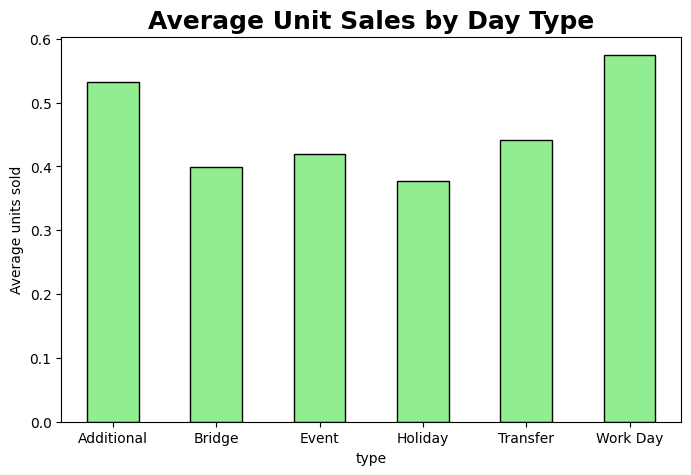

In [25]:
# 4. Compare average sales for each holiday type
# 1–2  average units sold for each day-type
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# 3  bar chart
holiday_sales.plot(kind='bar', figsize=(8,5), color='lightgreen', edgecolor='black')
plt.title('Average Unit Sales by Day Type', fontsize=18, weight='bold')
plt.ylabel('Average units sold')
plt.xticks(rotation=0)
plt.show()

In [26]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [27]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
df_train_items.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,family,class,perishable
0,2013-01-27,1028557,24,96995,1.0,False,2013,1,27,6,1.000000,GROCERY I,1093,False
1,2013-01-28,0,24,96995,0.0,0,2013,1,28,0,0.500000,GROCERY I,1093,False
2,2013-01-29,0,24,96995,0.0,0,2013,1,29,1,0.333333,GROCERY I,1093,False
3,2013-01-30,0,24,96995,0.0,0,2013,1,30,2,0.250000,GROCERY I,1093,False
4,2013-01-31,0,24,96995,0.0,0,2013,1,31,3,0.200000,GROCERY I,1093,False


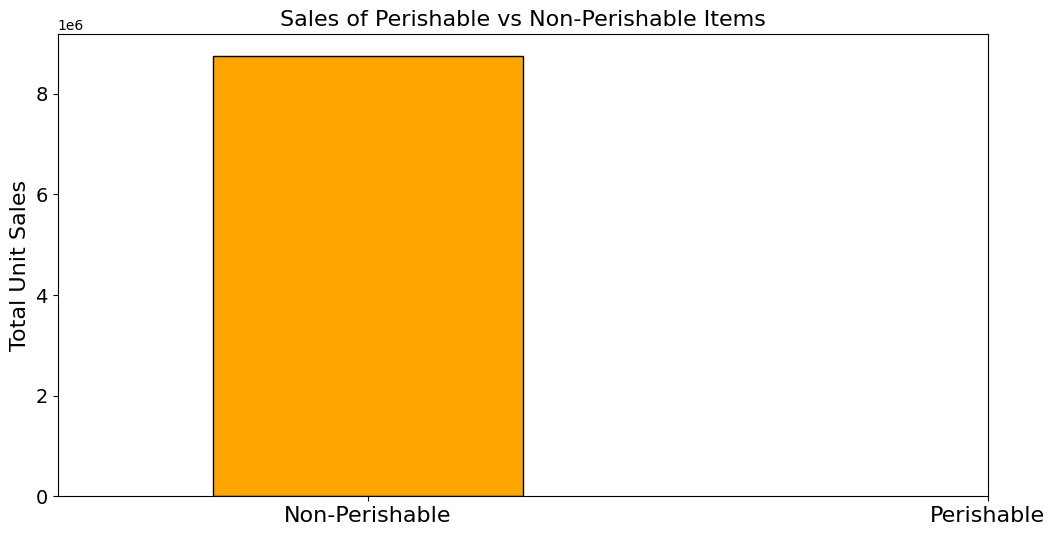

In [28]:
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()
df_train.to_csv("df_train_sda_hol_per.csv", index=False)

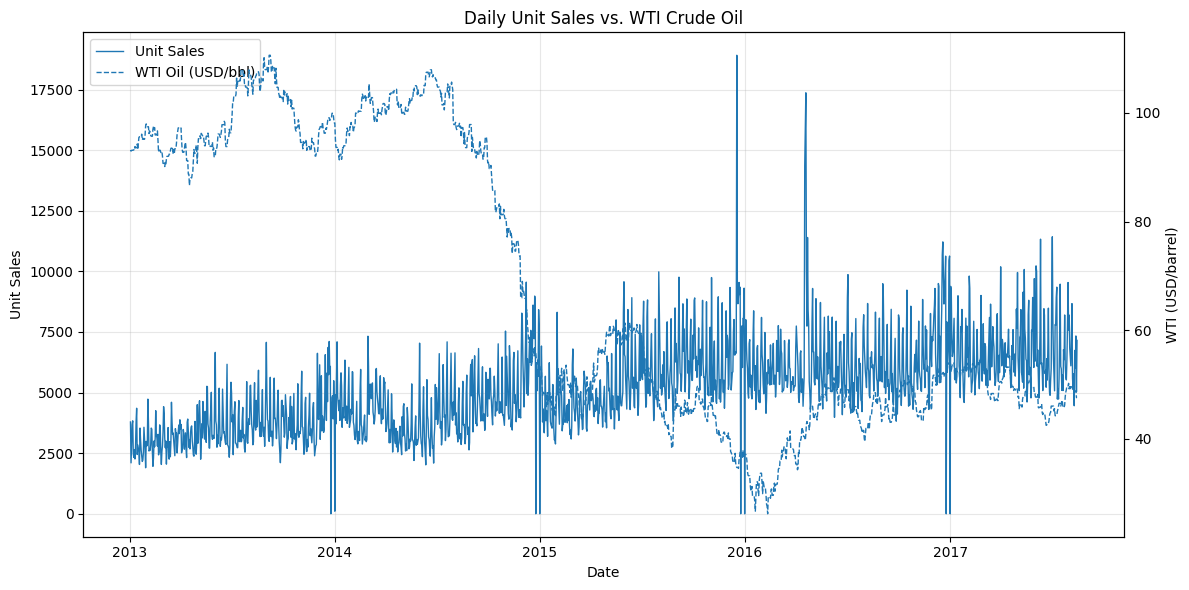

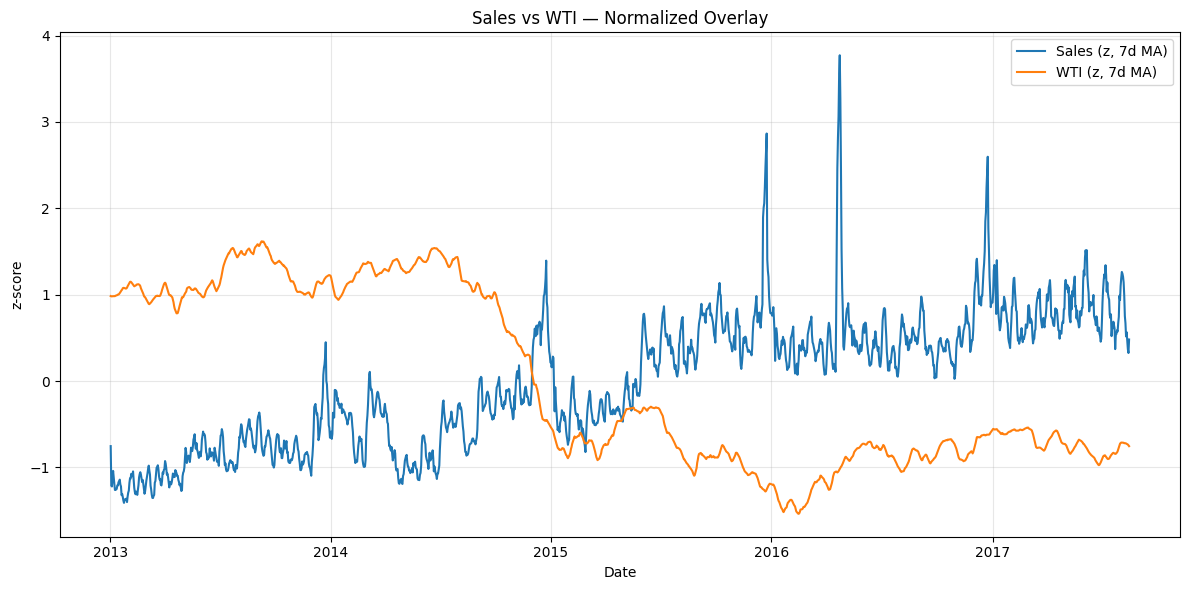

In [29]:
# --- Oil vs Sales: align & plot ---

import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime for oil (you already did for df_train)
df_oil['date'] = pd.to_datetime(df_oil['date'])

# 1) Daily total sales
daily_sales = (
    df_train
    .groupby('date', as_index=False)['unit_sales']
    .sum()
    .sort_values('date')
)

# 2) Continuous daily oil series (fill non-trading days)
oil_daily = (
    df_oil[['date', 'dcoilwtico']]
    .sort_values('date')
    .set_index('date')
    .asfreq('D')        # calendar daily
    .ffill()            # carry forward last price
    .reset_index()
)

# 3) Merge
merged_oil_sales = daily_sales.merge(oil_daily, on='date', how='left')
merged_oil_sales['dcoilwtico'] = merged_oil_sales['dcoilwtico'].bfill()

# 4) Dual-axis plot (original scales)
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()

ax1.plot(merged_oil_sales['date'], merged_oil_sales['unit_sales'], label='Unit Sales', linewidth=1)
ax2.plot(merged_oil_sales['date'], merged_oil_sales['dcoilwtico'], label='WTI Oil (USD/bbl)', linewidth=1, linestyle='--')

ax1.set_title('Daily Unit Sales vs. WTI Crude Oil')
ax1.set_xlabel('Date')
ax1.set_ylabel('Unit Sales')
ax2.set_ylabel('WTI (USD/barrel)')
ax1.grid(True, alpha=0.3)

# unified legend
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc='upper left')

plt.tight_layout()
plt.show()

# Normalized overlay to compare movements on one axis:
z = lambda s: (s - s.mean()) / s.std(ddof=0)
zdf = merged_oil_sales.assign(
      sales_z = z(merged_oil_sales['unit_sales']).rolling(7, min_periods=1).mean(),
      oil_z   = z(merged_oil_sales['dcoilwtico']).rolling(7, min_periods=1).mean()
)
plt.figure(figsize=(12,6))
plt.plot(zdf['date'], zdf['sales_z'], label='Sales (z, 7d MA)')
plt.plot(zdf['date'], zdf['oil_z'],   label='WTI (z, 7d MA)')
plt.title('Sales vs WTI — Normalized Overlay')
plt.xlabel('Date'); plt.ylabel('z-score'); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

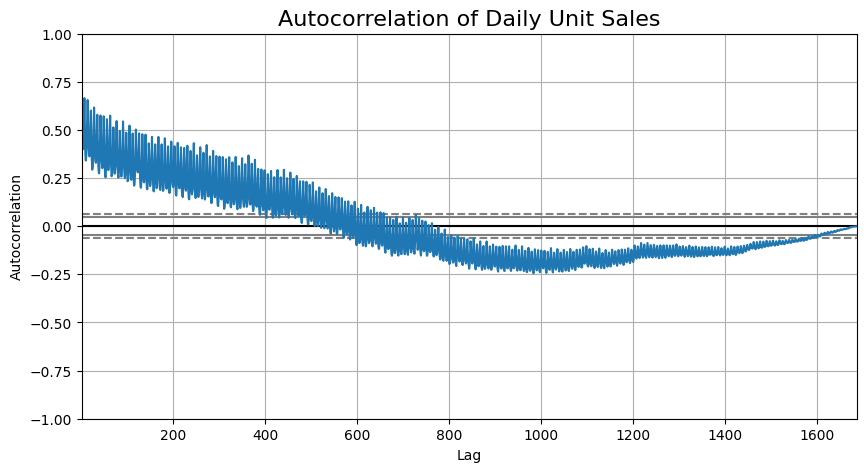

In [30]:
from pandas.plotting import autocorrelation_plot

# Aggregate total sales per day
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.show()


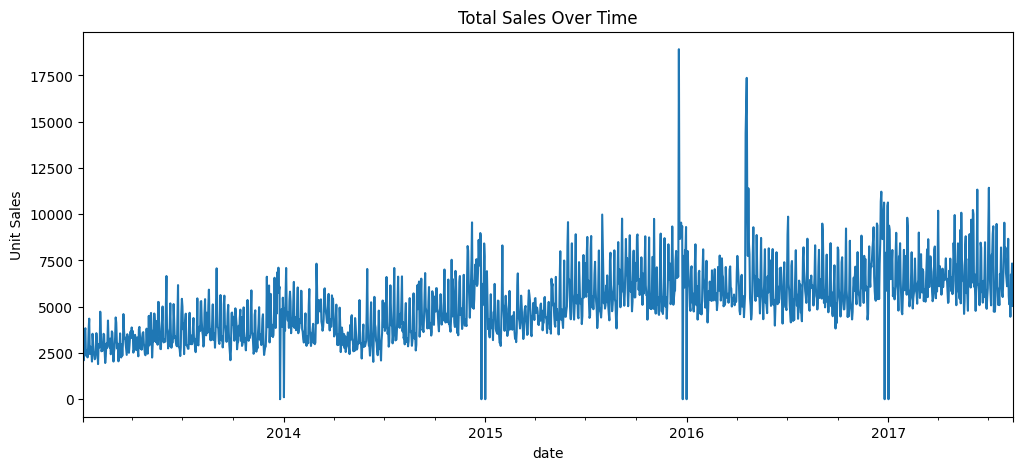

In [31]:
sales_by_date.plot(figsize=(12,5), title='Total Sales Over Time')
plt.ylabel('Unit Sales')
plt.show()


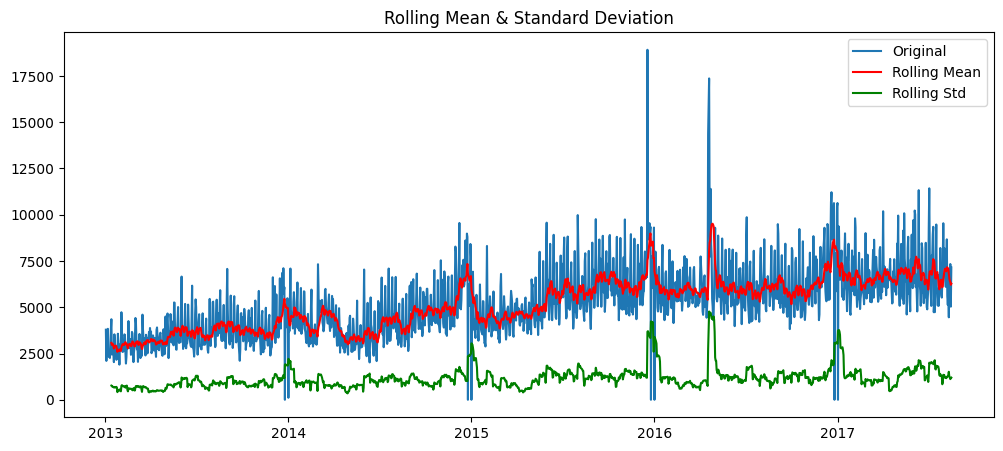

In [32]:
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [33]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_by_date)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.924296543948068
p-value: 0.04259471466827125


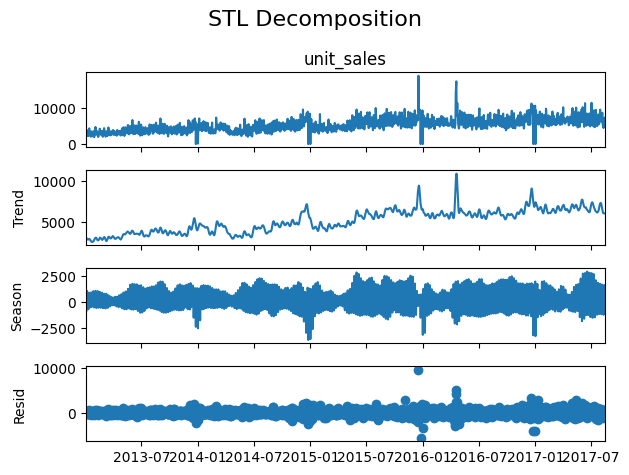

In [34]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# STL decomposition
stl = STL(sales_by_date, period=7)  # again, adjust period based on your seasonality
res = stl.fit()

# Plot STL decomposition
res.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
# Calculate strength of trend and seasonality
# Based on Hyndman’s definition: Strength = 1 - (variance of remainder / variance of (component + remainder))

import numpy as np

trend_strength = 1 - (np.var(res.resid) / np.var(res.trend + res.resid))
seasonal_strength = 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid))

print(f"Strength of Trend: {trend_strength:.2f}")
print(f"Strength of Seasonality: {seasonal_strength:.2f}")

Strength of Trend: 0.81
Strength of Seasonality: 0.67


In [38]:
import os

# Define folder path
folder_path = "/content/drive/MyDrive/time series modelling"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Define full file path
output_path = os.path.join(folder_path, "guayas_prepared.csv")

# Save DataFrame
df_train.to_csv(output_path, index=False)

print(f"✅ Saved file to: {output_path}")

✅ Saved file to: /content/drive/MyDrive/time series modelling/guayas_prepared.csv
